<a href="https://colab.research.google.com/github/relhwigi/GE_GRAPE_Mammogram_Classification/blob/main/Mammography_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning using Grammatical Evolution**
###Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Mounting drive***

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### ***Clone grammar repository***

In [2]:
import os.path

PATH = '/content/drive/MyDrive/GE_GRAPE_Mammogram_Classification/'
if os.path.exists(PATH):
    print('fyp directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/relhwigi/GE_GRAPE_Mammogram_Classification.git
    print('Cloning fyp repo in your Drive')

fyp directory already exists


### ***Clone GRAPE repository***

In [3]:
PATH = '/content/drive/MyDrive/grape/'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /content/drive/MyDrive/grape/

grape directory already exists
/content/drive/MyDrive/grape


In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### ***Importing libraries***

In [5]:
!pip install deap==1.3 

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg, greater_than_or_equal, less_than_or_equal

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

     |████████████████████████████████| 152 kB 3.2 MB/s 


### ***Data Exploration***

There are 2 datasets availble. A larger data set containing the full data and a smaller data set containing a subset of the data.

**Large dataset**

In [6]:
# loading in the full dataset into a pandas dataframe from GitHub
full_data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02.csv')

# checking the data
full_data.head()

,PatientID,StudyID,PatientAge,ImgID,View,SegmentPosition,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,...,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,Label
0,optm1,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,65,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,CC,LA1,0.019791,70.750121,0.986798,2679.422225,0.280588,147.661857,10646.938779,7.747646,11.202839,0.000314,4.076002,-0.375260,0.997168,0.019626,84.163154,0.984285,2677.867573,0.265944,147.683884,10627.307136,7.747549,11.323964,0.000289,4.197319,-0.358078,0.996413,0.019630,77.824490,0.985561,2694.966117,0.275523,147.909924,10702.039977,7.754164,...,0.009253,87.836024,0.972762,1612.354750,0.234180,125.710824,6361.582974,7.734123,11.454076,0.000271,4.262486,-0.325168,0.994130,0.009331,78.661818,0.975880,1630.642198,0.251513,125.959761,6443.906973,7.742087,11.349892,0.000295,4.170668,-0.341879,0.995351,0.009309,91.440624,0.971643,1612.335914,0.236469,125.710631,6357.903033,7.732227,11.447468,0.000271,4.279557,-0.326134,0.994207,0
1,optm1,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,65,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,CC,RA1,0.994207,-0.326134,4.279557,0.000271,11.447468,7.732227,6357.903033,125.710631,0.236469,1612.335914,0.971643,91.440624,0.009309,0.995351,-0.341879,4.170668,0.000295,11.349892,7.742087,6443.906973,125.959761,0.251513,1630.642198,0.975880,78.661818,0.009331,0.994130,-0.325168,4.262486,0.000271,11.454076,7.734123,6361.582974,125.710824,...,0.996896,-0.368340,4.131941,0.000304,11.259636,7.754164,10702.039977,147.909924,0.275523,2694.966117,0.985561,77.824490,0.019630,0.996413,-0.358078,4.197319,0.000289,11.323964,7.747549,10627.307136,147.683884,0.265944,2677.867573,0.984285,84.163154,0.019626,0.997168,-0.375260,4.076002,0.000314,11.202839,7.747646,10646.938779,147.661857,0.280588,2679.422225,0.986798,70.750121,0.019791,0
2,optm1,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,65,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,CC,LB1,0.176898,29.279795,0.991535,1729.360146,0.543738,69.492803,6888.160789,5.588478,7.678311,0.001063,3.007836,-0.466993,0.995340,0.176755,38.247695,0.988937,1728.676323,0.527879,69.472768,6876.457598,5.587467,7.788665,0.001018,3.140099,-0.444989,0.994189,0.176731,36.386574,0.989479,1729.238136,0.536824,69.479784,6880.565969,5.589269,...,0.092548,49.175862,0.974096,949.183578,0.426549,70.014061,3747.558450,6.123452,8.832584,0.000764,3.565872,-0.374187,0.991387,0.092727,41.654020,0.978061,949.293642,0.442741,70.019677,3755.520550,6.123813,8.724835,0.000808,3.457819,-0.394026,0.993063,0.092775,43.496564,0.977087,949.179329,0.434262,70.013911,3753.220753,6.121706,8.761205,0.000787,3.495691,-0.387325,0.992537,0
3,optm1,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,65,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,CC,RB1,0.992537,-0.387325,3.495691,0.000787,8.761205,6.121706,3753.220753,70.013911,0.434262,949.179329,0.977087,43.496564,0.092775,0.993063,-0.394026,3.457819,0.000808,8.724835,6.123813,3755.520550,70.019677,0.442741,949.293642,0.978061,41.654020,0.092727,0.991387,-0.374187,3.565872,0.000764,8.832584,6.123452,3747.558450,70.014061,...,0.994659,-0.453387,3.096423,0.001041,7.746667,5.589269,6880.565969,69.479784,0.536824,1729.238136,0.989479,36.386574,0.176731,0.994189,-0.444989,3.140099,0.001018,7.788665,5.587467,6876.457598,69.472768,0.527879,1728.676323,0.988937,38.247695,0.176755,0.995340,-0.466993,3.007836,0.001063,7.678311,5.588478,6888.160789,69.492803,0.543738,1729.360146,0.991535,29.279795,0.176898,0
4,optm1,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,65,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,CC,LC1,0.525843,7.001352,0.994143,597.735239,0.796829,25.326144,2383.939606,2.888570,3.765628,0.003221,1.616226,-0.557700,0.972441,0.526075,8.623873,0.992788,597.848247,0.789314,25.3

**Smaller dataset**

In [7]:
# loading in the sample dataset into a pandas dataframe from GitHub
some_data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

# checking the data
some_data.tail()

,PatientID,StudyID,PatientAge,ImgID,View,SegmentPosition,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,...,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,Label
24994,optm1344,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,66,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,MLO,LC4,0.580839,3.045049,0.997699,661.727190,0.836922,26.268896,2643.863713,2.494799,3.163219,0.003258,1.314591,-0.599526,0.966099,0.580497,7.801042,0.994106,661.792593,0.815975,26.252181,2639.369329,2.496087,3.296281,0.003155,1.509786,-0.539391,0.955178,0.580715,5.653316,0.995729,661.779929,0.824111,26.248573,2641.466402,2.496146,...,0.740933,4.768997,0.996091,609.972040,0.893421,17.894553,2435.119162,1.634581,2.096980,0.004058,0.990489,-0.595274,0.911536,0.740852,5.103426,0.995816,609.850151,0.896355,17.890689,2434.297178,1.635636,2.084555,0.004073,0.977859,-0.603467,0.913760,0.740632,7.332761,0.993989,609.970714,0.890533,17.894517,2432.550097,1.636074,2.120537,0.004044,1.030084,-0.579495,0.907051,0
24995,optm1344,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,66,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,MLO,RC4,0.907051,-0.579495,1.030084,0.004044,2.120537,1.636074,2432.550097,17.894517,0.890533,609.970714,0.993989,7.332761,0.740632,0.913760,-0.603467,0.977859,0.004073,2.084555,1.635636,2434.297178,17.890689,0.896355,609.850151,0.995816,5.103426,0.740852,0.911536,-0.595274,0.990489,0.004058,2.096980,1.634581,2435.119162,17.894553,...,0.959646,-0.562159,1.439089,0.003190,3.244839,2.496146,2641.466402,26.248573,0.824111,661.779929,0.995729,5.653316,0.580715,0.955178,-0.539391,1.509786,0.003155,3.296281,2.496087,2639.369329,26.252181,0.815975,661.792593,0.994106,7.801042,0.580497,0.966099,-0.599526,1.314591,0.003258,3.163219,2.494799,2643.863713,26.268896,0.836922,661.727190,0.997699,3.045049,0.580839,0
24996,optm1344,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,66,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,MLO,LD4,0.826577,0.954606,0.998275,276.728460,0.940576,9.732558,1105.959234,1.102387,1.339445,0.007334,0.598755,-0.672619,0.861793,0.826406,3.155421,0.994277,275.694855,0.929461,9.693805,1099.623999,1.102562,1.406288,0.007233,0.706477,-0.601921,0.837899,0.826833,1.641757,0.997022,275.683547,0.935430,9.694291,1101.092433,1.100626,...,0.954617,0.496889,0.997059,84.471798,0.983721,2.450195,337.390304,0.332656,0.396962,0.005391,0.206537,-0.708741,0.594332,0.954392,0.957006,0.994345,84.616243,0.982837,2.456086,337.507966,0.334070,0.402915,0.005385,0.219292,-0.691725,0.589005,0.954291,1.905002,0.988724,84.475163,0.981381,2.450326,335.995648,0.334633,0.412324,0.005377,0.236487,-0.658832,0.577138,0
24997,optm1344,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,66,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,MLO,RD4,0.577138,-0.658832,0.236487,0.005377,0.412324,0.334633,335.995648,2.450326,0.981381,84.475163,0.988724,1.905002,0.954291,0.589005,-0.691725,0.219292,0.005385,0.402915,0.334070,337.507966,2.456086,0.982837,84.616243,0.994345,0.957006,0.954392,0.594332,-0.708741,0.206537,0.005391,0.396962,0.332656,337.390304,2.450195,...,0.851051,-0.640413,0.648221,0.007284,1.367621,1.100626,1101.092433,9.694291,0.935430,275.683547,0.997022,1.641757,0.826833,0.837899,-0.601921,0.706477,0.007233,1.406288,1.102562,1099.623999,9.693805,0.929461,275.694855,0.994277,3.155421,0.826406,0.861793,-0.672619,0.598755,0.007334,1.339445,1.102387,1105.959234,9.732558,0.940576,276.728460,0.998275,0.954606,0.826577,0
24998,optm1344,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,66,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,MLO,LE4,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.00

**Extracting information on the data**

*Size of full dataset*

In [8]:
# number of rows in full dataset
full_number_of_samples = full_data['PatientID'].count()
full_number_of_samples

405280

*Size of sample dataset*

In [9]:
# number of rows in some dataset
some_number_of_samples = some_data['PatientID'].count()
some_number_of_samples

24999

*Visualisation of size difference*

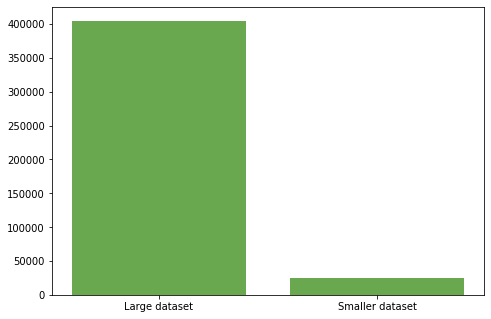

In [10]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sets = ['Large dataset', 'Smaller dataset']
samples = [full_number_of_samples, some_number_of_samples]
ax.bar(sets,samples, color="#6aa84f")
plt.show()

*Full dataset label distribution*

In [11]:
# number of positive and negative cases in full dataset
full_label_distribution = full_data['Label'].value_counts()
full_label_distribution

0    393021
1     12259
Name: Label, dtype: int64


*Visualisation of label distribution*

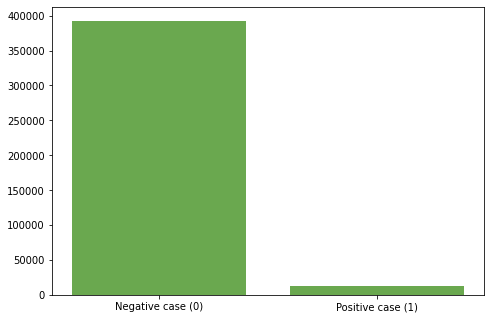

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label = ['Negative case (0)', 'Positive case (1)']
ax.bar(label , full_label_distribution, color="#6aa84f")
plt.show()

*Some dataset label distribution*

In [13]:
# number of positive and negative cases in some dataset
some_label_distribution = some_data['Label'].value_counts()
some_label_distribution

0    24018
1      981
Name: Label, dtype: int64

*Mammogram views*

In [14]:
# the different mammogram views in the dataset
views = full_data.View.unique()
views

array(['CC', 'MLO', 'XCCL', 'ML', 'LM'], dtype=object)

In [15]:
# getting the number of times each row occurs
CC_popularity = len(full_data.loc[full_data['View'] == 'CC'])
MLO_popularity = len(full_data.loc[full_data['View'] == 'MLO'])
XCCL_popularity = len(full_data.loc[full_data['View'] == 'XCCL'])
ML_popularity = len(full_data.loc[full_data['View'] == 'ML'])
LM_popularity = len(full_data.loc[full_data['View'] == 'LM'])

In [16]:
CC_popularity

205520

In [17]:
MLO_popularity

199320

In [18]:
XCCL_popularity

120

In [19]:
ML_popularity

240

In [20]:
LM_popularity

80

*Percentage of samples that are CC or MLO view*

In [21]:
((CC_popularity+MLO_popularity)/full_number_of_samples)*100

99.89143308330043

*Mammogram segments*

In [22]:
# the different mammogram segments in the dataset
segments = full_data.SegmentPosition.unique()
segments

array(['LA1', 'RA1', 'LB1', 'RB1', 'LC1', 'RC1', 'LD1', 'RD1', 'LE1',
       'RE1', 'LA2', 'RA2', 'LB2', 'RB2', 'LC2', 'RC2', 'LD2', 'RD2',
       'LE2', 'RE2', 'LA3', 'RA3', 'LB3', 'RB3', 'LC3', 'RC3', 'LD3',
       'RD3', 'LE3', 'RE3', 'LA4', 'RA4', 'LB4', 'RB4', 'LC4', 'RC4',
       'LD4', 'RD4', 'LE4', 'RE4'], dtype=object)

*Approximate number of patients in full dataset*

In [23]:
len(full_data.PatientID.unique())

4919

Approximate number of patients in sample dataset

In [24]:
len(some_data.PatientID.unique())

315

*Columns in the datasets*

In [25]:
number_of_all_columns = len(full_data.columns)
number_of_all_columns

111

In [26]:
# the column names in both datasets are the same, extracting them here
all_columns = full_data.columns.to_list()

### ***Data Preprocessing***

The data is already very clean and concise but there are a few columns that are unnecessary for the task at hand. 

**Dropping columns from large dataset**

In [27]:
full_data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)
final_columns = full_data.columns.to_list()

**Dropping columns from smaller dataset**

In [28]:
some_data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

**Number of columns remaining**

In [29]:
final_number_of_columns = len(final_columns)
final_number_of_columns

105

In [41]:
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(full_data), columns=full_data.columns)

In [42]:
df_norm.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,...,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,Label
0,0.019791,0.036315,0.146912,2.129597e-01,0.019037,0.304597,0.200497,0.016358,0.768941,2.362572e-08,0.624378,0.000213,0.997168,0.019626,0.037325,0.165911,2.128398e-01,0.018864,0.304434,0.199878,0.016359,0.773934,2.172271e-08,0.633089,0.000453,0.996413,0.019630,0.063528,0.146531,2.141802e-01,0.018687,0.304901,0.201637,0.016372,0.807204,2.287117e-08,0.710419,0.000215,0.996896,0.019545,...,0.009253,0.034052,0.167261,1.212125e-01,0.016788,0.265425,0.119859,0.015943,0.776862,2.154216e-08,0.633720,0.000544,0.994130,0.009331,0.056169,0.147198,1.225537e-01,0.017190,0.265970,0.121197,0.015959,0.805059,2.346650e-08,0.702896,0.000240,0.995351,0.009309,0.035801,0.148849,1.212112e-01,0.016231,0.265425,0.119729,0.015950,0.776658,2.157346e-08,0.637030,0.000341,0.994207,0.0
1,0.994207,0.000341,0.637030,2.157346e-08,0.776658,0.015950,0.119729,0.265425,0.016231,1.212112e-01,0.148849,0.035801,0.009309,0.995351,0.000240,0.702896,2.346650e-08,0.805059,0.015959,0.121197,0.265970,0.017190,1.225537e-01,0.147198,0.056169,0.009331,0.994130,0.000544,0.633720,2.154216e-08,0.776862,0.015943,0.119859,0.265425,0.016788,1.212125e-01,0.167261,0.034052,0.009253,0.995952,...,0.996896,0.000215,0.710419,2.287117e-08,0.807204,0.016372,0.201637,0.304901,0.018687,2.141802e-01,0.146531,0.063528,0.019630,0.996413,0.000453,0.633089,2.172271e-08,0.773934,0.016359,0.199878,0.304434,0.018864,2.128398e-01,0.165911,0.037325,0.019626,0.997168,0.000213,0.624378,2.362572e-08,0.768941,0.016358,0.200497,0.304597,0.019037,2.129597e-01,0.146912,0.036315,0.019791,0.0
2,0.176898,0.015325,0.147617,1.374491e-01,0.036890,0.143350,0.129714,0.011799,0.527024,7.992757e-08,0.460755,0.000178,0.995340,0.176755,0.017175,0.166695,1.373971e-01,0.037443,0.143210,0.129332,0.011798,0.532314,7.652525e-08,0.473628,0.000391,0.994189,0.176731,0.030132,0.147114,1.374297e-01,0.036410,0.143225,0.129637,0.011801,0.555359,7.827042e-08,0.532383,0.000183,0.994659,0.176427,...,0.092548,0.019222,0.167490,7.135706e-02,0.030579,0.147827,0.070608,0.012623,0.599062,6.071972e-08,0.530153,0.000504,0.991387,0.092727,0.030075,0.147527,7.134579e-02,0.030259,0.147850,0.070634,0.012624,0.618861,6.418799e-08,0.582764,0.000217,0.993063,0.092775,0.017218,0.149683,7.135684e-02,0.029807,0.147827,0.070679,0.012628,0.594408,6.255017e-08,0.520354,0.000310,0.992537,0.0
3,0.992537,0.000310,0.520354,6.255017e-08,0.594408,0.012628,0.070679,0.147827,0.029807,7.135684e-02,0.149683,0.017218,0.092775,0.993063,0.000217,0.582764,6.418799e-08,0.618861,0.012624,0.070634,0.147850,0.030259,7.134579e-02,0.147527,0.030075,0.092727,0.991387,0.000504,0.530153,6.071972e-08,0.599062,0.012623,0.070608,0.147827,0.030579,7.135706e-02,0.167490,0.019222,0.092548,0.994230,...,0.994659,0.000183,0.532383,7.827042e-08,0.555359,0.011801,0.129637,0.143225,0.036410,1.374297e-01,0.147114,0.030132,0.176731,0.994189,0.000391,0.473628,7.652525e-08,0.532314,0.011798,0.129332,0.143210,0.037443,1.373971e-01,0.166695,0.017175,0.176755,0.995340,0.000178,0.460755,7.992757e-08,0.527024,0.011799,0.129714,0.143350,0.036890,1.374491e-01,0.147617,0.015325,0.176898,0.0
4,0.525843,0.004050,0.148006,4.750783e-02,0.054061,0.052243,0.044893,0.006099,0.258465,2.421615e-07,0.247587,0.000143,0.972441,0.526075,0.004175,0.167344,4.751763e-02,0.055987,0.052187,0.044815,0.006095,0.260232,2.395671e-07,0.252375,0.000324,0.969807,0.526078,0.009356,0.147359,4.754255e-02,0.053600,0.052196,0.044884,0.006096,0.274106,2.398855e-07,0.291902,0.000152,0.968830,0.525539,...,0.330231,0.011034,0.168346,4.999964e-02,0.046953,0.078498,0.049599,0.008338,0.383477,1.246505e-07,0.376168,0.000452,0.978911,0.330643,0.013449,0.148786,4.998920e-02,0.045943,0.078511,0.049699,0.008339,0.392256,1.2

In [43]:
df_norm['x0'].count()

405280

**Train and test split**

In [45]:
X = np.zeros([full_number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([full_number_of_samples,], dtype=int)

for i in range(full_number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = df_norm['x'+ str(j)].iloc[i]

for i in range(full_number_of_samples):
    Y[i] = df_norm['Label'].iloc[i]
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [46]:
print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print('Test (X,Y):\t', X_test.shape, Y_test.shape)

Training (X,Y):	 (283696, 104) (283696,)
Test (X,Y):	 (121584, 104) (121584,)


In [47]:
print(Counter(Y_train))

Counter({0: 275168, 1: 8528})


In [48]:
print(Counter(Y_test))

Counter({0: 117853, 1: 3731})


**Oversample train data**

In [49]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(X_train, Y_train)
# new class distribution 
print(Counter(y_ros))

Counter({0: 275168, 1: 275168})


**Get transpose of X arrays**

In [50]:
X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

### ***BNF Grammar***

**Check grammar file**

In [51]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar7.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<segment_a>,<segment_b>)|sub(<segment_a>,<segment_b>)|pdiv(<segment_a>,<segment_b>)|mul(<segment_a>,<segment_b>)|<decimal>|<segment_a>|add(<segment_b>,<segment_a>)|sub(<segment_b>,<segment_a>)|pdiv(<segment_b>,<segment_a>)|mul(<segment_b>,<segment_a>)|<segment_b>
<decimal> ::= <n><n>.<n><n>
<segment_a> ::= x[0]|x[1]|x[2]|x[3]|x[4]|x[5]|x[6]|x[7]|x[8]|x[9]|x[10]|x[11]|x[12]|x[13]|x[14]|x[15]|x[16]|x[17]|x[18]|x[19]|x[20]|x[21]|x[22]|x[23]|x[24]|x[25]|x[26]|x[27]|x[28]|x[29]|x[30]|x[31]|x[32]|x[33]|x[34]|x[35]|x[36]|x[37]|x[38]|x[39]|x[40]|x[41]|x[42]|x[43]|x[44]|x[45]|x[46]|x[47]|x[48]|x[49]|x[50]|x[51]
<segment_b> ::= x[52]|x[53]|x[54]|x[55]|x[56]|x[57]|x[58]|x[59]|x[60]|x[61]|x[62]|x[63]|x[64]|x[65]|x[66]|x[67]|x[68]|x[69]|x[70]|x[71]|x[72]|x[73]|x[74]|x[75]|x[76]|x[77]|x[78]|x[79]|x[80]|x[81]|x[82]|x[83]|x[84]|x[85]|x[86]|x[87]|x[88]|x[89]|x[90]|x[91]|x[92]|x[93]|x[94]|x[95]|x[96]|x[97]|x[98]|x[99]|x[100]|x[101]|x[102]|x[103]
<n> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9


**Setup grammar**

In [52]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar7.bnf")

         Unit productions consume GE codons.


### ***Fitness Function***

In [53]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  compare= np.equal(Y,Y_class)
  fitness= 1 - np.mean(compare)

  return fitness,

### ***Grammatical Evolution***

**Setting GE parameters**

In [57]:
POPULATION_SIZE = 1000
MAX_GENERATIONS = 100
P_CROSSOVER = 0.8
P_MUTATION = 0.02
ELITE_SIZE = round(0.01*POPULATION_SIZE)
HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 11
MIN_INIT_TREE_DEPTH = 6
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 255

**Creating DEAP toolbox**

In [58]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

toolbox.register("select", ge.selTournament, tournsize=5)

toolbox.register("mate", ge.crossover_onepoint)

toolbox.register("mutate", ge.mutation_int_flip_per_codon)

**Main function**

In [59]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg    	std     	min      	max    	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.86253	0.210892	0.0381112	0.96994	0.03864     	4              	4.35      	9         	0             	110.438        
1  	92     	0.690028	0.288037	0.0375508	0.96994	0.039043    	4              	4.448     	12        	0.00922346    	103.112        
2  	96     	0.458666	0.282927	0.0374591	0.96994	0.0389772   	5              	4.74      	12        	0.0102701     	99.3771        
3  	87     	0.301467	0.26468 	0.0374591	0.96994	0.0389772   	5              	5.096     	16        	0.0102141     	107.246        
4  	83     	0.227455	0.244213	0.0374591	0.96994	0.0389772   	5              	5.349     	13        	0.00864267    	106.07         
5  	49     	0.208218	0.247224	0.0374591	0.96994	0.0389772   	5              	5.672     	15        	0.00974298    	109.131        
6  	42     	0.213228	0.254711	0.0374591	0.96994	0.0389772   	5              	5.985     	14  

**Statistics**

In [60]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.862530,0.210892,0.038111,0.969940,0.038640,4,4.350,9,0.000000,110.437916
1,1,92,0.690028,0.288037,0.037551,0.969940,0.039043,4,4.448,12,0.009223,103.112160
2,2,96,0.458666,0.282927,0.037459,0.969940,0.038977,5,4.740,12,0.010270,99.377097
3,3,87,0.301467,0.264680,0.037459,0.969940,0.038977,5,5.096,16,0.010214,107.245514
4,4,83,0.227455,0.244213,0.037459,0.969940,0.038977,5,5.349,13,0.008643,106.070266
5,5,49,0.208218,0.247224,0.037459,0.969940,0.038977,5,5.672,15,0.009743,109.131197
6,6,42,0.213228,0.254711,0.037459,0.969940,0.038977,5,5.985,14,0.009530,107.421853
7,7,28,0.222753,0.262878,0.037459,0.969940,0.038977,5,6.399,14,0.009080,110.923988
8,8,34,0.210677,0.264910,0.037459,0.969940,0.038977,5,6.735,14,0.009581,111.582983
9,9,14,0.195054,0.258906,0.037459,0.952551,0.038977,5,7.199,17,0.010226,117.729793


**Best individual**

In [61]:
print("Best individual: ")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual: 
sub(x[9],x[65])

Training Fitness:  0.03745911116124301

Depth:  3

Length of the genome:  5

Used portion of the genome: 0.60



**Best individuals plots**

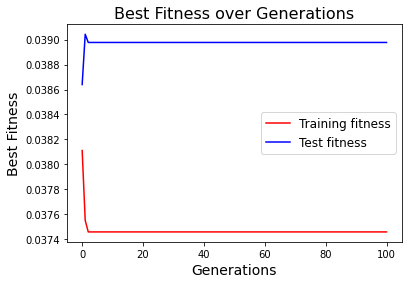

In [62]:
plt.plot(gen, min_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.show()

**Average fitness plot**

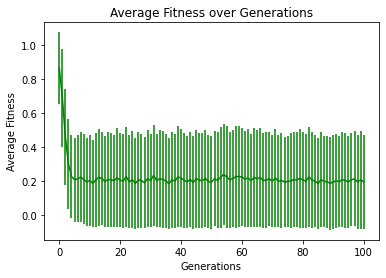

In [63]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

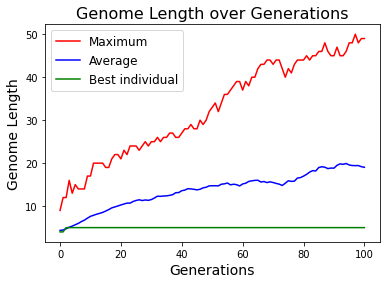

In [64]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()